In [2]:
import gymnasium as gym 
import os
import numpy as np
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics 

In [3]:
class MonteCarlo:
    def __init__(self, environment_name, episodes, epsilon = 0.2, alpha=0.2, gamma=0.95):
        self.env = gym.make(environment_name)
        self.episodes = episodes
        self.episode_data = 500
        self.param = alpha
        self.ep_rewards_table = {'ep': [], 'avg_'+str(self.param): [], 'min_'+str(self.param): [], 'max_'+str(self.param): [], 'std_'+str(self.param): [], 'mid_'+str(self.param): []}
        
        # Initialize Q
        self.space_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.number_bins = 50
        self.Q = np.random.randn(self.number_bins, self.number_bins, self.number_bins, self.number_bins, self.action_size)
        self.C = np.zeros_like(self.Q)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def select_e_greedy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])

    def discretize_state(self, observation):
        pos_index = np.argmin(np.abs(np.linspace(self.lower_bounds[0], self.upper_bounds[0], num=self.number_bins).tolist() - observation[0]))
        vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[1], self.upper_bounds[1], num=self.number_bins).tolist() - observation[1]))
        ang_index = np.argmin(np.abs(np.linspace(self.lower_bounds[2], self.upper_bounds[2], num=self.number_bins).tolist() - observation[2]))
        ang_vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[3], self.upper_bounds[3], num=self.number_bins).tolist() - observation[3]))
        return pos_index, vel_index, ang_index, ang_vel_index

    def test_q(self):
        state, info = self.env.reset()
        score = 0 
        epsilon = 0.0
        d_state = self.discretize_state(state)
        action = self.select_e_greedy(d_state, epsilon)
        terminated = False
        truncated = False
        while not (terminated or truncated or score > 500):
            state_prime, reward, terminated, truncated, info = self.env.step(action)
            d_state_prime = self.discretize_state(state_prime)
            action_prime = self.select_e_greedy(d_state_prime, epsilon)
            d_state = d_state_prime
            action = action_prime
            score += reward
        self.env.close()
        return score

    def train(self):
        ep_rewards = []
        ep_rewards_t = []

        for episode in range(1, self.episodes + 1):
            state, info = self.env.reset()
            score = 0 
            d_state = self.discretize_state(state)
            #action = self.select_e_greedy(d_state, self.epsilon)
            terminated = False
            truncated = False
            episode_states = []
            episode_actions = []
            episode_rewards = []
            
            
            while not (terminated or truncated or score > 500):
                action = self.select_e_greedy(d_state, self.epsilon)
                episode_states.append(d_state)
                episode_actions.append(action)
                
                state_prime, reward, terminated, truncated, _ = self.env.step(action)
                d_state_prime = self.discretize_state(state_prime)
                episode_rewards.append(reward)
                
                if terminated or truncated:
                    break
                
                d_state = d_state_prime

            ep_rewards.append(sum(episode_rewards))
            
            G = 0
            W = 1
            for t in range(len(episode_states)):
                t = len(episode_states)-t-1
                
                state_t = episode_states[t]
                action_t = episode_actions[t]
                G = episode_rewards[t] + self.gamma * sum(episode_rewards[t+1:])
                
                self.C[state_t + (action_t,)] += W
                self.Q[state_t + (action_t,)] += W/self.C[state_t + (action_t,)] * (G - self.Q[state_t + (action_t,)])
                W = W
            

            t_score = self.test_q()
            ep_rewards.append(score)
            ep_rewards_t.append(t_score)

            if not episode % self.episode_data:
                avg_reward = sum(ep_rewards_t[-self.episode_data:]) / len(ep_rewards_t[-self.episode_data:])
                self.ep_rewards_table['ep'].append(episode)
                self.ep_rewards_table['avg_'+str(self.param)].append(avg_reward)
                self.ep_rewards_table['min_'+str(self.param)].append(min(ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['max_'+str(self.param)].append(max(ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['std_'+str(self.param)].append(np.std(ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['mid_'+str(self.param)].append(statistics.median(ep_rewards_t[-self.episode_data:]))
                
                print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards_t[-self.episode_data:])} max:{max(ep_rewards_t[-self.episode_data:])} std:{np.std(ep_rewards_t[-self.episode_data:])}")

        self.env.close()

In [4]:
gammas = [1, 0.95, 0.9, 0.85, 0.8]
episodes = 50001
episode_data = 500
environment_name = "CartPole-v1"
agents_mc_g = []

for gamma in gammas:
    print(f"gamma = {gamma}")
    agent = MonteCarlo(environment_name, episodes, epsilon = 0.2, alpha= 0.4, gamma= gamma)
    agent.train()
    agents_mc_g.append(agent)

gamma = 1
Episode:500 avg:32.004 min:9.0 max:312.0 std:23.421272040604457
Episode:1000 avg:39.092 min:10.0 max:189.0 std:22.732081646870792
Episode:1500 avg:47.05 min:13.0 max:256.0 std:27.592453678496952
Episode:2000 avg:57.622 min:14.0 max:361.0 std:35.351988854942796
Episode:2500 avg:73.668 min:12.0 max:500.0 std:56.53676481724082
Episode:3000 avg:92.748 min:14.0 max:500.0 std:77.10621567681817
Episode:3500 avg:125.108 min:12.0 max:500.0 std:117.15156138950944
Episode:4000 avg:144.454 min:14.0 max:500.0 std:131.4288548378932
Episode:4500 avg:178.114 min:16.0 max:500.0 std:144.28606656222908
Episode:5000 avg:183.392 min:18.0 max:500.0 std:143.79911799451344
Episode:5500 avg:219.066 min:17.0 max:500.0 std:172.12607485212692
Episode:6000 avg:222.658 min:22.0 max:500.0 std:162.42434865499692
Episode:6500 avg:261.23 min:25.0 max:500.0 std:168.03872500111396
Episode:7000 avg:252.266 min:20.0 max:500.0 std:159.0667383333172
Episode:7500 avg:263.506 min:26.0 max:500.0 std:160.18969368845177

/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

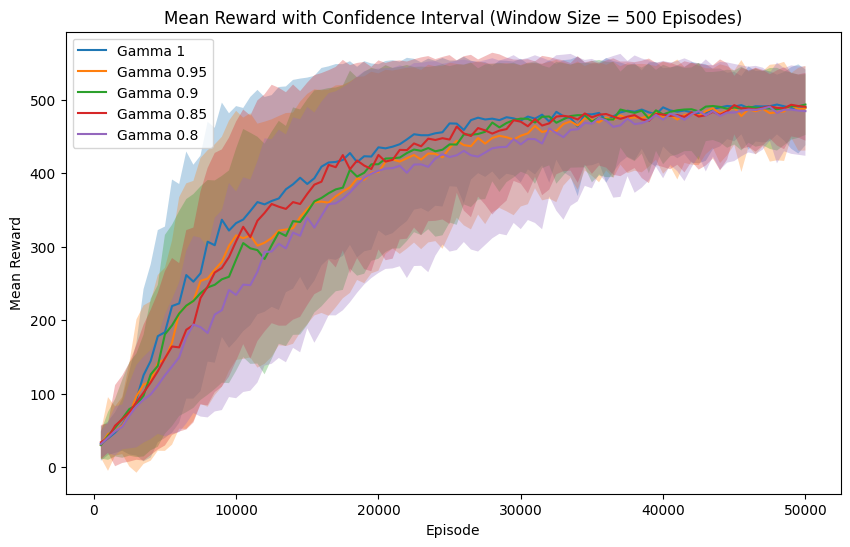

In [6]:
plt.figure(figsize=(10, 6))


for agent in agents_mc_g:
    #print(agent)
    if agent.param > 0:
        df = pd.DataFrame(agent.ep_rewards_table)


        # Plot the mean rewards as a main line
        sns.lineplot(data=df, x='ep', y='avg_'+str(agent.param), label='Gamma '+str(agent.gamma))

        # Fill the area between (mean - std) and (mean + std) as the interval
        plt.fill_between(df['ep'], df['avg_'+str(agent.param)] - df['std_'+str(agent.param)], df['avg_'+str(agent.param)] + df['std_'+str(agent.param)], alpha=0.3)

# Customize the plot
plt.title('Mean Reward with Confidence Interval (Window Size = 500 Episodes)')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.legend()

# Show the plot
plt.show()

In [ ]:
epsilons = [0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
#alphas = [0.9, 0.8]
episodes = 50001
episode_data = 500
environment_name = "CartPole-v1"
agents_mc_ep = []

for epsilon in epsilons:
    print(f"epsilon = {epsilon}")
    agent = MonteCarlo(environment_name, episodes, epsilon = epsilon, alpha= 0.7, gamma= 1)
    agent.train()
    agents_mc_ep.append(agent)